In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install import_ipynb 
!conda install -c conda-forge import_ipynb

/Users/gabesmithline/miniconda3/lib/python3.10/site-packages/conda/base/context.py:200: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-arm64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - import_ipynb

Current channels:

  - https://conda.anaconda.org/conda-forge
  - defaults
  - https://conda.anaconda.org/pytorch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at

In [3]:
import sys

# Add the parent directory to sys.path
sys.path.append('../')

from game_runner import NegotitaionGame
from eval.game_evaluator import GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass, field

# Add the main project directory to sys.path
sys.path.append('/Users/gabesmithline/Desktop/caif_negotiation/')

# Import the notebook
import import_ipynb
%run '../test_game_eval.ipynb'  # Run the notebook directly
import torch
from utils.offer import Offer

from prompts.make_prompt import make_prompt
from prompts.make_prompt_bargain import make_prompt_bargain
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)

# Initialize the DataFrame to store pathology results
pathology_results = pd.DataFrame()  # Store total game pathology results
# Add COLUMNS
envy_results_history = {}

Matplotlib created a temporary cache directory at /var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/matplotlib-qq8u33m9 because the default path (/Users/gabesmithline/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


Outside offer consistency: True
Offer increasing: False
Envy-free (strict): True
Envy-free (excluding one item): True

Player 1:
Outside offer value: 50.0
Offer 1:
  Offer: tensor([1, 1, 2, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 90 = tensor([10, 20, 30, 40]) · tensor([1, 1, 2, 0])
    Kept value: 140 = 230 - 90
  Value of kept items: 140
Offer 2:
  Offer: tensor([2, 1, 3, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 130 = tensor([10, 20, 30, 40]) · tensor([2, 1, 3, 0])
    Kept value: 100 = 230 - 130
  Value of kept items: 100

Player 2:
Outside offer value: 40.0
Offer 1:
  Offer: tensor([2, 1, 2, 1])
  Player values: tensor([40, 30, 20, 10])
  Value calculation:
    Total value: 270 = tensor([40, 30, 20, 10]) · tensor([3, 2, 4, 1])
    Given value: 160 = tensor([

In [4]:
def calculate_discounted_value(offer, values, gamma, round_num):
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (round_num - 1))


In [5]:

import time
#prompt_style = 'llama_3.1_405b_maximize_value_outside_offer_example_cot'
#prompt_style = 'openai_4o_maximize_value_outside_offer_cot'
# prompt_style = 'bargain_maximize_results_outside_offer_emphasized_with_example'
#prompt_style = 'anthropic_3.5_sonnet_maximize_value_outside_offer_cot'
prompt_style = 'gemini_2.0_flash_maximize_value_outside_offer_cot'
date = '12_15_2024'
max_rounds = 3

def calculate_discounted_value(offer, values, gamma, realization_round):
    """
    Calculate the discounted value of an offer.

    Parameters:
    - offer: List of item quantities.
    - values: List of item values for the player.
    - gamma: Discount factor.
    - realization_round: The round when the payoff is realized.
    """
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (realization_round - 1))

rounds = []
p1_values = []
p2_values = []
games = 100  

pathology_results = pd.DataFrame()
envy_results_history = {}

for i in range(games):
    if (i + 1) % 10 == 0:
        print(f"Game {i + 1} of {games}")
        time.sleep(2 * 60)  #Sleep for 2 minutes

    rounds = []
    p1_values = []
    p2_values = []
    p1_offers = []
    p2_offers = []

    game = NegotitaionGame(
        player1_agent=llm_agent.LLMAgent(llm_type="gemini", player_num=0),
        player2_agent=llm_agent.LLMAgent(llm_type="gemini", player_num=1),
        num_items=5,
        item_value_range=[1, 101],
        gamma=0.9,
        max_rounds=max_rounds,
        outside_offer_value_range=[1, 1000]
    )

    game_history = GameHistory(
        agent_1_name="Agent1",
        agent_2_name="Agent2",
        num_items=game.num_items,
        items=torch.tensor(game.items),
        agent_1_values=torch.tensor(game.player_values[0]),
        agent_2_values=torch.tensor(game.player_values[1]),
        agent_1_outside_value=game.outside_offer_values[0],
        agent_2_outside_value=game.outside_offer_values[1]
    )

    game_history.agent_1_offers = []
    game_history.agent_2_offers = []

    game.game_results = pd.DataFrame(columns=[  # Set up dataframe to store game pathology results
        "game_num", "round_num", "player", "discount_rate", "offer", "value", "items",
        "your_side_of_current_offer", "outside_offer", "accepting_an_offer_worse_than_outside_offer",
        "making_an_offer_worse_for_you_than_your_outside_offer",
        "walking_away_from_an_offer_better_than_your_outside_offer",
        "offer_no_items_or_all_items", "making_offer_worse_than_previous"
    ])

    while game.in_progress:
        current_step = len(game.history[0]) + len(game.history[1]) + 1
        current_round = (current_step - 1) // 2 + 1
        current_player = 1 if current_step % 2 == 1 else 2
        game.current_round = current_round
        your_side_of_current_offer = None
        '''
        PATHOLOGIES
        '''
        making_offer_worse_than_previous = False  # Only occurs in non-final rounds
        making_offer_worse_than_outside_offer = False  # Only occurs in non-final rounds
        offer_no_items_or_all_items = False  # Only occurs in non-final rounds
        accepting_an_offer_worse_than_outside_offer = False  # Only occurs in final round
        walking_away_from_an_offer_better_than_outside_offer = False  # Only occurs in final round

        print(f"\n{'=' * 80}")
        print(f"Game {i + 1}, Round {current_round}, Player {current_player}'s turn (Step {current_step})")
        print(f"{'=' * 80}")

        prev_offer = game.current_offer
        game.step()

        if game.current_offer: 

            if game.players[current_player - 1].action == "COUNTEROFFER":
                if current_player == 1:
                    realization_round_p1 = current_round
                    realization_round_p2 = current_round
                else:
                    realization_round_p1 = current_round + 1
                    realization_round_p2 = current_round + 1
            else:
                realization_round_p1 = current_round
                realization_round_p2 = current_round

            #calculate values with realization rounds
            # Corrected value calculations
            if current_player == 1:
                p1_kept = game.items - np.array(game.current_offer.offer)
                p2_kept = np.array(game.current_offer.offer)
            else:
                p1_kept = np.array(game.current_offer.offer)
                p2_kept = game.items - np.array(game.current_offer.offer)

            p1_value = calculate_discounted_value(
                p1_kept, game.player_values[0], game.gamma, realization_round_p1
            )
            p2_value = calculate_discounted_value(
                p2_kept, game.player_values[1], game.gamma, realization_round_p2
            )

            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            if current_player == 1:
                p1_offers.append(game.current_offer.offer)
            else:
                p2_offers.append(game.current_offer.offer)
                print(f"\nRound {current_round} Values:")
                print(f"Player 1: {p1_value:.2f}")
                print(f"Player 2: {p2_value:.2f}")

            '''
            PATHOLOGY 1: Immediate offer was worse than the offer you just rejected
            '''
            if game.players[current_player - 1].action == "COUNTEROFFER":
                if (game.current_round == 1 and current_player == 2) or game.current_round > 1:
                    if current_player == 1:
                        your_side_of_previous_offer = p1_values[-2]  #P1's value from P2's previous offer
                        your_side_of_current_offer = p1_values[-1]  #P1's value from the current offer
                    else:
                        your_side_of_previous_offer = p2_values[-2]  #P2's value from P1's previous offer
                        your_side_of_current_offer = p2_values[-1]  #P2's value from the current offer

                    if your_side_of_previous_offer > your_side_of_current_offer:
                        making_offer_worse_than_previous = True
                    else:
                        making_offer_worse_than_previous = False

                '''
                PATHOLOGY 2: Immediate offer was worse than your outside offer
                '''
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value < outside_offer:
                        making_offer_worse_than_outside_offer = True
                    else:
                        making_offer_worse_than_outside_offer = False
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                    if p2_value < outside_offer:
                        making_offer_worse_than_outside_offer = True
                    else:
                        making_offer_worse_than_outside_offer = False
            else:
                making_offer_worse_than_outside_offer = False

            '''
            PATHOLOGY 3: Offer had no items or all items
            '''
            if game.players[current_player - 1].action == "COUNTEROFFER":
                if (np.array_equal(game.current_offer.offer, [0] * game.num_items) or
                        np.array_equal(game.current_offer.offer, game.items)):
                    offer_no_items_or_all_items = True
                else:
                    offer_no_items_or_all_items = False

            '''
            PATHOLOGY 4: Accepting an offer worse than your outside offer
            '''
            if game.final_action_player.action == "ACCEPT":
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value < outside_offer:
                        accepting_an_offer_worse_than_outside_offer = True
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                    if p2_value < outside_offer:
                        accepting_an_offer_worse_than_outside_offer = True

            '''
            PATHOLOGY 5: Walking away from an offer better than your outside offer
            '''
            if game.final_action_player.action == "WALK" or (
                    current_player == 2 and
                    game.players[current_player - 1].action == "COUNTEROFFER" and
                    game.current_round == game.max_rounds):
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value > outside_offer:
                        walking_away_from_an_offer_better_than_outside_offer = True
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                    if p2_value > outside_offer:
                        walking_away_from_an_offer_better_than_outside_offer = True

            game.game_results = pd.concat([game.game_results, pd.DataFrame([{
                "game_num": i,
                "round_num": current_round,
                "player": current_player,
                "discount_rate": game.gamma ** (current_round - 1),
                "offer": game.current_offer.offer,
                "value": p1_value if current_player == 1 else p2_value,
                "items": game.items,
                "your_side_of_current_offer": your_side_of_current_offer,
                "outside_offer": outside_offer,
                "accepting_an_offer_worse_than_outside_offer": accepting_an_offer_worse_than_outside_offer,
                "making_an_offer_worse_for_you_than_your_outside_offer": making_offer_worse_than_outside_offer,
                "walking_away_from_an_offer_better_than_your_outside_offer": walking_away_from_an_offer_better_than_outside_offer,
                "offer_no_items_or_all_items": offer_no_items_or_all_items,
                "making_offer_worse_than_previous": making_offer_worse_than_previous
            }])], ignore_index=True)

        '''
        FINAL POSSIBLE ROUND PRINT STATEMENTS
        '''
        if game.current_offer is not None and len(game.current_offer.offer) == game.num_items:
            
            game_history.add_offer(
                game.current_player,
                Offer(game.current_player, offer=torch.tensor(game.current_offer.offer))
            )

        if current_round == game.max_rounds and current_player == 2:
            if game.current_offer and game.current_offer != prev_offer:
                print(f"\nPlayer 2's final action: COUNTEROFFER {game.current_offer.offer}")
                p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                print("\nGame ended after max rounds - both players get outside offers")
            elif game.current_offer == prev_offer:
                print("\nPlayer 2's final action: ACCEPT")
                p1_kept = game.items - np.array(game.current_offer.offer)
                p1_value = calculate_discounted_value(
                    p1_kept, game.player_values[0], game.gamma, current_round
                )
                p2_value = calculate_discounted_value(
                    game.current_offer.offer, game.player_values[1], game.gamma, current_round
                )
            else:
                
                print("\nPlayer 2's final action: WALK")
                p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                print("\nGame ended after max rounds - both players get outside offers")

            game.in_progress = False
            print(f"\nRound {current_round} Final Values:")
            print(f"Player 1: {p1_value:.2f}")
            print(f"Player 2: {p2_value:.2f}")

            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            break
        elif game.current_offer is None and current_player == 1 and game.final_action_player.action == "WALK":
            # If Player 1 makes an invalid offer
            game.game_results = pd.concat([game.game_results, pd.DataFrame([{
                "game_num": i,
                "round_num": current_round,
                "player": current_player,
                "discount_rate": game.gamma ** (current_round - 1),
                "offer": [],
                "value": None,
                "items": game.items,
                "your_side_of_current_offer": None,
                "outside_offer": None,
                "accepting_an_offer_worse_than_outside_offer": None,
                "making_an_offer_worse_for_you_than_your_outside_offer": None,
                "walking_away_from_an_offer_better_than_your_outside_offer": None,
                "offer_no_items_or_all_items": None,
                "making_offer_worse_than_previous": None
            }])], ignore_index=True)
            game.in_progress = False

    pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)
    envy_results_history[i] = game_history

pathology_results.to_csv(f'pathology_results_{date}_{games}_{prompt_style}.csv', index=False)

# pd.DataFrame.from_dict(envy_results_history, orient='index').to_csv(
#     f'envy_results_{date}_{games}_{prompt_style}.csv', index=False
# )


Game 1, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 6 units of item 2, 2 units of item 3, 1 units of item 4, 7 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 55 for item 1, 35 for item 2, 31 for item 3, 94 for item 4, 30 for item 5.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 993. Your objective is to maximize your value of the outcome of the negotiation game. Remember, you have a guaranteed alternative: your outside offer.

    Before making any counteroffer, you should ca

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation step by step.\n\n**1) Current Situation:**\n\n*   **My Outside Offer Value:** 221\n*   **My Item Values:**\n    *   Item 1: 71 per unit\n    *   Item 2: 5 per unit\n    *   Item 3: 37 per unit\n    *   Item 4: 10 per unit\n    *   Item 5: 85 per unit\n*   **Current Offer:** Player 1 is offering me [0, 0, 0, 0, 1], meaning 0 units of items 1-4 and 1 unit of item 5.\n*   **Round:** 1\n*   **Discount Factor (gamma):** 0.9\n\n**2) Calculations:**\n\n*   **Value of Accepting Current Offer:**\n    *   1 unit of item 5: 1 * 85 = 85\n    *   Total value: 85\n    *   Discounted value: 85 * (0.9^0) = 85\n\n*   **Value of Different Counteroffers:**\n    Let's consider some counteroffers and their value, bearing in min

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my best action.\n\n**1) Analyze the current situation:**\n\n*   **My outside offer value:** 925\n*   **My item values:**\n    *   Item 1: 42\n    *   Item 2: 68\n    *   Item 3: 17\n    *   Item 4: 77\n    *   Item 5: 60\n*   **Current offer:** None (no offer has been made yet)\n*   **Round:** 1\n*   **Discount factor:** gamma = 0.9\n\n**2) Calculate:**\n\n*   **Current offer value:** Since there is no current offer, my value is 0.\n\n*   **Potential counteroffers:** I need to consider different divisions and see how they compare to my outside offer. I will calculate a few options, keeping in mind my goal is to maximize my own value:\n    *   **Option 1: Offer Player 2 nothing:** This means I 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my best course of action in this negotiation.\n\n**1) Analyzing the Current Situation:**\n\n*   **My Outside Offer Value:** 384\n*   **My Item Values:**\n    *   Item 1: 90\n    *   Item 2: 64\n    *   Item 3: 1\n    *   Item 4: 41\n    *   Item 5: 43\n*   **Current Offer:** Player 1 is offering me [1, 1, 1, 1, 0] which means 1 unit of item 1, 1 unit of item 2, 1 unit of item 3, 1 unit of item 4, and 0 units of item 5.\n*   **Round and Discount Factor:** It's round 1, and the discount factor (gamma) is 0.9. So, the discount is 0.9^(1-1) = 0.9^0 = 1, so no discount this round.\n\n**2) Calculating Values:**\n\n*   **Value of Accepting the Current Offer:**\n    *   1 unit of item 1: 1 * 90 = 90\n

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my best action in round 1.\n\n**1) Analyze the Current Situation:**\n\n*   **My Outside Offer Value:** 497\n*   **My Item Values:**\n    *   Item 1: 10\n    *   Item 2: 17\n    *   Item 3: 30\n    *   Item 4: 6\n    *   Item 5: 79\n*   **Current Offer:** None (this is the first round)\n*   **Round:** 1\n*   **Discount Factor:** gamma = 0.9. The discount factor for round 1 is 0.9^(1-1) = 0.9^0 = 1.\n\n**2) Calculate:**\n\n*   **Current Offer Value:** Since there is no current offer, this doesn't apply.\n*   **Potential Counteroffers:** I need to consider making an offer. I want to maximize my value while considering that Player 2 wants to maximize theirs. Given my outside offer is 497, I must t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and decide on my action.\n\n**1) Current Situation:**\n\n*   **Outside Offer Value:** 312\n*   **My Item Values:**\n    *   Item 1: 20\n    *   Item 2: 54\n    *   Item 3: 13\n    *   Item 4: 76\n    *   Item 5: 95\n*   **Current Offer:** Player 1 is offering me [3, 6, 0, 1, 0], meaning they are giving me 3 units of item 1, 6 units of item 2, 0 units of item 3, 1 unit of item 4 and 0 unit of item 5.\n*   **Round:** 1\n*   **Discount Factor:** gamma = 0.9. For round 1, the discount factor is 0.9^(1-1) = 0.9^0 = 1.\n\n**2) Calculations:**\n\n*   **Value of Current Offer:**\n    *   Item 1: 3 * 20 = 60\n    *   Item 2: 6 * 54 = 324\n    *   Item 3: 0 * 13 = 0\n    *   Item 4: 1 * 76 = 76\n    *   Item 5: 0 * 9

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and decide on the best action for Player 2 in this negotiation.\n\n**1) Analyze the current situation:**\n\n*   **Outside offer value:** 346\n*   **My item values:** \n    *   Item 1: 53\n    *   Item 2: 18\n    *   Item 3: 5\n    *   Item 4: 21\n    *   Item 5: 67\n*   **Current offer:** Player 1 is offering me [3, 2, 2, 2, 2] which means I would receive 3 units of item 1, 2 units of item 2, 2 units of item 3, 2 units of item 4 and 2 units of item 5.\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculate potential values:**\n\n*   **Value of accepting the current offer:**\n    *   3 units of item 1: 3 * 53 = 159\n    *   2 units of item 2: 2 * 18 = 36\n    *   2 units of item 3: 2 * 5 = 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and make a decision for Round 1.\n\n**1) Analyze the current situation:**\n\n*   **My outside offer value:** 109\n*   **My item values:**\n    *   Item 1: 38\n    *   Item 2: 78\n    *   Item 3: 79\n    *   Item 4: 8\n    *   Item 5: 45\n*   **Current offer:** None\n*   **Round:** 1\n*   **Discount factor:** gamma = 0.9,  discount factor is 0.9^(1-1) = 1 (no discount)\n\n**2) Calculate potential values:**\n\nSince there's no current offer, I only need to consider potential counteroffers and compare them to my outside offer. I'll aim for a division that maximizes my value while leaving some value for Player 2, to incentivize them to accept in later rounds.\n\nLet's consider a few example divisions and see ho

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my best action.\n\n**1) Analyze the current situation:**\n\n*   **My outside offer value:** 581\n*   **My item values:**\n    *   Item 1: 87\n    *   Item 2: 1\n    *   Item 3: 51\n    *   Item 4: 76\n    *   Item 5: 91\n*   **Current offer:** Player 1 is offering me [0, 2, 2, 2, 1]. This means I would get:\n    *   0 units of item 1\n    *   2 units of item 2\n    *   2 units of item 3\n    *   2 units of item 4\n    *   1 unit of item 5\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculate values:**\n\n*   **Value of accepting the current offer:**\n    *   0 * 87 + 2 * 1 + 2 * 51 + 2 * 76 + 1 * 91 = 0 + 2 + 102 + 152 + 91 = 347\n*   **Value of accepting the current offer 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation step-by-step.\n\n**1) Current Situation:**\n\n*   **Outside Offer Value:** 716\n*   **Item Values (per unit):**\n    *   Item 1: 62\n    *   Item 2: 80\n    *   Item 3: 4\n    *   Item 4: 94\n    *   Item 5: 6\n*   **Current Offer:** Player 1 is offering me [0, 0, 0, 1, 0]. This means they are offering me 0 units of item 1, 0 units of item 2, 0 units of item 3, 1 unit of item 4, and 0 units of item 5.\n*   **Round:** 1\n*   **Discount Factor:** gamma = 0.9, so the discount factor for round 1 is 0.9^(1-1) = 0.9^0 = 1.\n\n**2) Calculations:**\n\n*   **Value of Current Offer:**\n    *   0 * 62 + 0 * 80 + 0 * 4 + 1 * 94 + 0 * 6 = 94\n    *   This value is significantly less than my outside offer of 716.\n\n*   

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine the best action for Player 1 in round 1.\n\n**1) Analyze the Current Situation:**\n\n*   **My outside offer value:** 621\n*   **My item values:**\n    *   Item 1: 50 per unit\n    *   Item 2: 68 per unit\n    *   Item 3: 58 per unit\n    *   Item 4: 11 per unit\n    *   Item 5: 55 per unit\n*   **Current offer:** None (This is the first round, no offer has been made yet).\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculate Values:**\n\nSince there is no current offer, we don't need to calculate the value of accepting. We need to consider our potential value from different counteroffers, compared to our outside offer.\nLet's examine some different offer options. To ensure 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation step-by-step.\n\n**1) Current Situation:**\n\n*   **Outside Offer Value:** 963\n*   **Item Values:**\n    *   Item 1: 23\n    *   Item 2: 73\n    *   Item 3: 13\n    *   Item 4: 47\n    *   Item 5: 12\n*   **Current Offer:** [0, 0, 2, 3, 0] (Player 1 is offering me 0 units of item 1, 0 units of item 2, 2 units of item 3, 3 units of item 4, and 0 units of item 5.)\n*   **Round:** 1\n*   **Discount Factor (gamma):** 0.9\n\n**2) Calculations:**\n\n*   **Value of Accepting Current Offer:**\n    *   Item 1: 0 * 23 = 0\n    *   Item 2: 0 * 73 = 0\n    *   Item 3: 2 * 13 = 26\n    *   Item 4: 3 * 47 = 141\n    *   Item 5: 0 * 12 = 0\n    *   Total Value = 0 + 0 + 26 + 141 + 0 = 167\n\n*   **Discounted Value of Acc

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation step-by-step.\n\n**1) Current Situation:**\n\n*   **My outside offer value:** 397\n*   **My item values:**\n    *   Item 1: 55\n    *   Item 2: 19\n    *   Item 3: 40\n    *   Item 4: 55\n    *   Item 5: 20\n*   **Current offer:** Player 1 is offering me [0, 1, 0, 1, 0], meaning I would receive 0 units of item 1, 1 unit of item 2, 0 units of item 3, 1 unit of item 4, and 0 units of item 5.\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculations:**\n\n*   **Value of current offer:**\n    *   0 units of item 1: 0 * 55 = 0\n    *   1 unit of item 2: 1 * 19 = 19\n    *   0 units of item 3: 0 * 40 = 0\n    *   1 unit of item 4: 1 * 55 = 55\n    *   0 units of item 5: 0 * 20 = 0\n    *   Tota

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation step-by-step.\n\n**1) Current Situation:**\n\n*   **My outside offer value:** 35\n*   **My item values:** \n    *   Item 1: 32\n    *   Item 2: 34\n    *   Item 3: 64\n    *   Item 4: 89\n    *   Item 5: 9\n*   **Current offer:** [0, 0, 0, 0, 0] (meaning Player 1 is offering me 0 units of each item)\n*   **Round:** 1\n*   **Discount factor:** gamma = 0.9\n\n**2) Calculations:**\n\n*   **Value of accepting current offer:**\n    *   0 units of item 1 = 0 * 32 = 0\n    *   0 units of item 2 = 0 * 34 = 0\n    *   0 units of item 3 = 0 * 64 = 0\n    *   0 units of item 4 = 0 * 89 = 0\n    *   0 units of item 5 = 0 * 9 = 0\n    *   Total value = 0\n\n*   **Comparison to outside offer:** The current offer value (0

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation step-by-step.\n\n**1) Analyzing the Current Situation:**\n\n*   **Outside Offer Value:** My outside offer value is 925.\n*   **My Item Values:** My values per unit are:\n    *   Item 1: 41\n    *   Item 2: 39\n    *   Item 3: 14\n    *   Item 4: 87\n    *   Item 5: 85\n*   **Current Offer:** Player 1 is offering me [0, 0, 1, 0, 0]. This means I would receive 0 units of item 1, 0 units of item 2, 1 unit of item 3, 0 units of item 4, and 0 units of item 5.\n*   **Round:** We are in Round 1.\n*   **Discount Factor:** The discount factor (gamma) is 0.9. The discount factor to be applied is 0.9^(1-1) = 0.9^0 = 1.\n\n**2) Calculations:**\n\n*   **Value of Accepting Current Offer:**\n    *   1 unit of item 3: 1 * 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my optimal action for round 1.\n\n**1) Current Situation:**\n\n*   **My outside offer value:** 782\n*   **My item values:**\n    *   Item 1: 100\n    *   Item 2: 38\n    *   Item 3: 1\n    *   Item 4: 11\n    *   Item 5: 73\n*   **Current offer:** None (This is the first round, so no offer has been made yet)\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculations:**\n\n*   **Current Offer Value:** Since there's no current offer, I can't calculate a value for accepting it.\n*   **Potential Counteroffer Values:** I need to consider possible counteroffers and their values to me. I must keep in mind that a deal must be better than my outside option of 782.\n\n   Here's a break

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine the best action for Player 2 in this negotiation.\n\n**1) Analyzing the current situation:**\n\n*   **Outside offer value:** 952\n*   **Item values:**\n    *   Item 1: 90\n    *   Item 2: 2\n    *   Item 3: 35\n    *   Item 4: 25\n    *   Item 5: 93\n*   **Current offer:** [0, 0, 0, 0, 0] (Player 1 is offering me 0 of each item)\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculating values:**\n\n*   **Value of accepting the current offer:**\n    Since the current offer is [0, 0, 0, 0, 0], this means I get 0 units of every item, yielding a value of 0.\n    Total value = (0 * 90) + (0 * 2) + (0 * 35) + (0 * 25) + (0 * 93) = 0\n    This is obviously much less than my outside 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:290: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation step-by-step.\n\n**1) Current Situation:**\n\n*   **My outside offer value:** 938\n*   **My item values:**\n    *   Item 1: 15\n    *   Item 2: 17\n    *   Item 3: 89\n    *   Item 4: 95\n    *   Item 5: 83\n*   **Current offer:** None (no offer on the table yet)\n*   **Round:** 1\n*   **Discount factor:** gamma = 0.9\n\n**2) Calculations:**\n\n*   **Current offer value:** Since there is no current offer, the value is 0.\n*   **Potential counteroffers:** I need to consider what division of items would be beneficial to me. I have the following units:\n    *   Item 1: 2\n    *   Item 2: 5\n    *   Item 3: 1\n    *   Item 4: 3\n    *   Item 5: 5\n    \n    My aim is to maximize the total value of items I keep.

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my best action.\n\n**1) Current Situation:**\n\n*   **My Outside Offer Value:** 915\n*   **My Item Values:**\n    *   Item 1: 6\n    *   Item 2: 24\n    *   Item 3: 97\n    *   Item 4: 36\n    *   Item 5: 80\n*   **Current Offer:** Player 1 is offering me [2, 5, 0, 0, 0] (2 units of item 1, 5 units of item 2, 0 units of items 3, 4, and 5).\n*   **Round:** 1\n*   **Discount Factor:** gamma = 0.9\n\n**2) Calculations:**\n\n*   **Value of Accepting Current Offer:**\n    *   2 units of item 1: 2 * 6 = 12\n    *   5 units of item 2: 5 * 24 = 120\n    *   0 units of item 3: 0 * 97 = 0\n    *   0 units of item 4: 0 * 36 = 0\n    *   0 units of item 5: 0 * 80 = 0\n    *   Total value: 12 + 120 + 0 + 0

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and decide on the best action for Player 2 in round 1.\n\n**1) Analyze the current situation:**\n\n*   **My outside offer value:** 670\n*   **My item values:**\n    *   Item 1: 12\n    *   Item 2: 46\n    *   Item 3: 45\n    *   Item 4: 47\n    *   Item 5: 22\n*   **Current offer:** [0, 0, 0, 0, 0] (Player 1 is offering me nothing)\n*   **Round:** 1\n*   **Discount factor:** gamma = 0.9.  The discount factor for this round is 0.9^(1-1) = 0.9^0 = 1. This means there is no discount for this round.\n\n**2) Calculate values:**\n\n*   **Value of accepting current offer:**\n    *   The current offer is [0, 0, 0, 0, 0], meaning I get 0 units of each item.\n    *   My total value would be 0 * 12 + 0 * 46 + 0 * 45 +

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my best course of action.\n\n**1) Current Situation Analysis:**\n\n*   **My outside offer value:** 40\n*   **My item values:**\n    *   Item 1: 26\n    *   Item 2: 95\n    *   Item 3: 98\n    *   Item 4: 35\n    *   Item 5: 23\n*   **Current offer:** Player 1 is offering me [0, 0, 0, 0, 0]. This means they are offering me 0 units of each item.\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculations:**\n\n*   **Value of accepting the current offer:** If I accept [0, 0, 0, 0, 0], I get 0 value from the items.  This is significantly worse than my outside offer.  (0 * 26) + (0 * 95) + (0 * 98) + (0 * 35) + (0 * 23) = 0\n*   **Value of my outside offer:** 40\n*   **Potential co

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and decide on my action.\n\n**1) Current Situation Analysis:**\n\n*   **Outside Offer Value:** My outside offer value is 26.\n*   **Item Values:** My private values are:\n    *   Item 1: 51\n    *   Item 2: 49\n    *   Item 3: 86\n    *   Item 4: 95\n    *   Item 5: 20\n*   **Current Offer:** Player 1 has offered me [3, 4, 2, 1, 1]. This means they get the rest: [6, 1, 2, 1, 1].\n*   **Round and Discount:** It is round 1, and the discount factor (gamma) is 0.9. The discount factor for this round is 0.9^(1-1) = 0.9^0 = 1.\n\n**2) Calculations:**\n\n*   **Value of Accepting Current Offer:**\n    *   3 units of item 1: 3 * 51 = 153\n    *   4 units of item 2: 4 * 49 = 196\n    *   2 units of item 3: 2 * 86 = 1

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine the best course of action.\n\n**1) Current Situation Analysis:**\n\n*   **My outside offer value:** 539\n*   **My item values:** Item 1: 55, Item 2: 71, Item 3: 36, Item 4: 33, Item 5: 92\n*   **Current offer:** Player 1 is offering me [0, 0, 0, 0, 1]. This means I receive 0 units of item 1, 0 units of item 2, 0 units of item 3, 0 units of item 4, and 1 unit of item 5.\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculations:**\n\n*   **Value of Accepting Current Offer:**\n    *   1 unit of item 5: 1 * 92 = 92\n    *   Total value of current offer: 92\n    *   Discounted value: 92 * (0.9^(1-1)) = 92 * 1 = 92\n\n*   **Comparing to Outside Offer:** My outside offer is 539.  T

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my best action.\n\n**1) Current Situation:**\n\n*   **My outside offer value:** 855\n*   **My item values:**\n    *   Item 1: 67\n    *   Item 2: 89\n    *   Item 3: 3\n    *   Item 4: 7\n    *   Item 5: 11\n*   **Current offer:** Player 1 is offering me [0, 2, 2, 1, 1] (meaning they keep [2, 5, 4, 4, 3]).\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculations:**\n\n*   **Value of accepting the current offer:**\n    *   0 units of item 1: 0 * 67 = 0\n    *   2 units of item 2: 2 * 89 = 178\n    *   2 units of item 3: 2 * 3 = 6\n    *   1 unit of item 4: 1 * 7 = 7\n    *   1 unit of item 5: 1 * 11 = 11\n    *   Total value = 0 + 178 + 6 + 7 + 11 = 202\n*   **Value of accep

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation step-by-step.\n\n**1) Current Situation:**\n\n*   **My outside offer value:** 773\n*   **My item values:**\n    *   Item 1: 22\n    *   Item 2: 72\n    *   Item 3: 36\n    *   Item 4: 67\n    *   Item 5: 54\n*   **Current offer:** Player 1 is offering me [2, 0, 2, 2, 0] (2 units of item 1, 0 of item 2, 2 of item 3, 2 of item 4, 0 of item 5).\n*   **Round:** 1\n*  **Discount factor:** gamma = 0.9, discount factor = 0.9^(1-1) = 1.0\n\n**2) Calculations:**\n\n*   **Value of current offer:**\n    *   2 units of item 1: 2 * 22 = 44\n    *   0 units of item 2: 0 * 72 = 0\n    *   2 units of item 3: 2 * 36 = 72\n    *   2 units of item 4: 2 * 67 = 134\n    *   0 units of item 5: 0 * 54 = 0\n    *   Total value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation step-by-step.\n\n**1) Analyze the current situation:**\n\n*   **Outside Offer Value:** My outside offer value is 162.\n*   **Item Values:** My values per unit are:\n    *   Item 1: 81\n    *   Item 2: 100\n    *   Item 3: 76\n    *   Item 4: 13\n    *   Item 5: 13\n*   **Current Offer:** Player 1 has offered me [0, 0, 5, 6, 4]. This means they want all the units of item 1 and 2 and none of 3,4,5 for themselves.\n*   **Round:** It is round 1.\n*   **Discount Factor:** The discount factor gamma is 0.9. Therefore the effective value at this round is 0.9^0 = 1\n\n**2) Calculate:**\n\n*   **Value of Accepting Current Offer:**\n    *   0 units of item 1 = 0 * 81 = 0\n    *   0 units of item 2 = 0 * 100 = 0\n    *

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation step-by-step and determine the best action for Player 2.\n\n**1) Analyze the current situation:**\n\n*   **My outside offer value:** 431\n*   **My item values:** Item 1: 17, Item 2: 21, Item 3: 46, Item 4: 98, Item 5: 86\n*   **Current offer:** Player 1 is offering me [4, 2, 5, 2, 0] units of items 1 through 5, respectively.\n*   **Round:** 1\n*   **Discount factor:** gamma = 0.9\n\n**2) Calculate values:**\n\n*   **Value of current offer:**\n    *   Item 1: 4 units * 17 = 68\n    *   Item 2: 2 units * 21 = 42\n    *   Item 3: 5 units * 46 = 230\n    *   Item 4: 2 units * 98 = 196\n    *   Item 5: 0 units * 86 = 0\n    *   Total value of current offer: 68 + 42 + 230 + 196 + 0 = 536\n\n*   **Compare to outsi

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation step-by-step.\n\n**1) Current Situation Analysis:**\n\n*   **My outside offer value:** 791\n*   **My item values:**\n    *   Item 1: 11\n    *   Item 2: 60\n    *   Item 3: 23\n    *   Item 4: 42\n    *   Item 5: 26\n*   **Current offer:** Player 1 is offering me [0, 2, 2, 0, 1] (meaning I get 0 of item 1, 2 of item 2, 2 of item 3, 0 of item 4, and 1 of item 5).\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculations:**\n\n*   **Value of accepting current offer:**\n    *   0 units of item 1 = 0 * 11 = 0\n    *   2 units of item 2 = 2 * 60 = 120\n    *   2 units of item 3 = 2 * 23 = 46\n    *   0 units of item 4 = 0 * 42 = 0\n    *   1 unit of item 5 = 1 * 26 = 26\n    *   Total value = 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze this negotiation step by step.\n\n**1) Analyze the current situation:**\n\n*   **My outside offer value:** 741\n*   **My item values:** 56 (item 1), 62 (item 2), 72 (item 3), 99 (item 4), 51 (item 5)\n*   **Current offer:** Player 1 is offering me [1, 0, 0, 0, 1] (1 unit of item 1 and 1 unit of item 5).\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculate values:**\n\n*   **Value of accepting the current offer:**\n    *   1 unit of item 1: 1 * 56 = 56\n    *   0 units of item 2: 0 * 62 = 0\n    *   0 units of item 3: 0 * 72 = 0\n    *   0 units of item 4: 0 * 99 = 0\n    *   1 unit of item 5: 1 * 51 = 51\n    *   Total value: 56 + 0 + 0 + 0 + 51 = 107\n*   **Value after discount (round 1):** 107 * (0

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my optimal action for round 1.\n\n**1) Current Situation:**\n\n*   **My Outside Offer Value:** 438\n*   **My Item Values:**\n    *   Item 1: 80\n    *   Item 2: 60\n    *   Item 3: 45\n    *   Item 4: 96\n    *   Item 5: 14\n*   **Current Offer:** None\n*   **Round:** 1\n*   **Discount Factor:** gamma = 0.9\n\n**2) Calculations:**\n\n*   **Current Offer Value:** Since there is no current offer, accepting would result in 0 value. This is clearly less than my outside offer value of 438.\n*   **Potential Counteroffers:** I need to figure out how to make an offer that will be beneficial to me, while also making it at least somewhat appealing to the other player. Let's consider a few options.\n\n  

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation step-by-step.\n\n**1) Current Situation Analysis:**\n\n*   **My Outside Offer Value:** 152\n*   **My Item Values:** \n    *   Item 1: 27\n    *   Item 2: 45\n    *   Item 3: 34\n    *   Item 4: 7\n    *   Item 5: 33\n*   **Current Offer:** Player 1 is offering me [3, 2, 1, 0, 2] units of items 1 through 5, respectively.\n*   **Round:** 1\n*   **Discount Factor:**  gamma = 0.9, but since it's round 1, the discount factor is 0.9^(1-1) = 0.9^0 = 1.\n\n**2) Calculations:**\n\n*   **Value of Accepting Current Offer:**\n    *   Item 1: 3 units * 27 = 81\n    *   Item 2: 2 units * 45 = 90\n    *   Item 3: 1 unit * 34 = 34\n    *   Item 4: 0 units * 7 = 0\n    *   Item 5: 2 units * 33 = 66\n    *   Total Value = 81

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my best action.\n\n**1) Current Situation Analysis:**\n\n*   **My outside offer value:** 705\n*   **My item values:**\n    *   Item 1: 56\n    *   Item 2: 62\n    *   Item 3: 6\n    *   Item 4: 10\n    *   Item 5: 78\n*   **Current offer:** Player 1 is offering me [3, 2, 0, 1, 0] (3 units of item 1, 2 units of item 2, 0 units of item 3, 1 unit of item 4, 0 units of item 5).\n*   **Round:** Round 1\n*   **Discount factor:** gamma = 0.9\n\n**2) Calculations:**\n\n*   **Value of accepting the current offer:**\n    *   3 units of item 1: 3 * 56 = 168\n    *   2 units of item 2: 2 * 62 = 124\n    *   0 units of item 3: 0 * 6 = 0\n    *   1 unit of item 4: 1 * 10 = 10\n    *   0 units of item 5: 0 *

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my optimal action.\n\n**1) Current Situation:**\n\n*   **My outside offer value:** 971\n*   **My item values:**\n    *   Item 1: 59\n    *   Item 2: 31\n    *   Item 3: 68\n    *   Item 4: 67\n    *   Item 5: 57\n*   **Current offer:** [0, 3, 2, 0, 1] (meaning Player 1 is offering me 0 of item 1, 3 of item 2, 2 of item 3, 0 of item 4, and 1 of item 5)\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculations:**\n\n*   **Value of accepting current offer:**\n    *   0 units of item 1: 0 * 59 = 0\n    *   3 units of item 2: 3 * 31 = 93\n    *   2 units of item 3: 2 * 68 = 136\n    *   0 units of item 4: 0 * 67 = 0\n    *   1 unit of item 5: 1 * 57 = 57\n    *   Total value: 0 +

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my best action.\n\n**1) Current Situation:**\n\n*   **My outside offer value:** 841\n*   **My item values:**\n    *   Item 1: 86\n    *   Item 2: 75\n    *   Item 3: 99\n    *   Item 4: 80\n    *   Item 5: 45\n*   **Current offer:** [0, 0, 0, 1, 1] (This means Player 1 is offering me 0 units of item 1, 0 units of item 2, 0 units of item 3, 1 unit of item 4, and 1 unit of item 5.)\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculations:**\n\n*   **Value of accepting the current offer:**\n    *   1 unit of item 4: 1 * 80 = 80\n    *   1 unit of item 5: 1 * 45 = 45\n    *   Total value: 80 + 45 = 125\n\n*   **Comparison to outside offer:**\n    *   My current offer value is 1

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my optimal action.\n\n**1) Current Situation:**\n\n*   **My outside offer value:** 802\n*   **My item values:**\n    *   Item 1: 50\n    *   Item 2: 55\n    *   Item 3: 80\n    *   Item 4: 1\n    *   Item 5: 55\n*   **Current offer:** None (no offer has been made yet)\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculations:**\n\n*   **Value of accepting current offer:** Since there is no current offer, accepting is not an option.\n*   **Potential counteroffers:** I need to consider offers that would give me a value greater than my outside offer. Here are a few potential counteroffers and their values to me. Since I have 3 units of Item 1, 1 of Item 2, 4 of Item 3, 5 of Ite

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation step-by-step.\n\n**1) Analyze the current situation:**\n\n*   **My outside offer value:** 847\n*   **My item values:**\n    *   Item 1: 100\n    *   Item 2: 18\n    *   Item 3: 70\n    *   Item 4: 97\n    *   Item 5: 49\n*   **Current offer:** Player 1 is offering me [0, 0, 0, 0, 0]\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculate:**\n\n*   **Value of accepting current offer:** If I accept the current offer of [0, 0, 0, 0, 0], my total value is 0 * 100 + 0 * 18 + 0 * 70 + 0 * 97 + 0 * 49 = 0.\n*   **Value of counteroffers:** I need to consider what counteroffer would be beneficial. My goal is to maximize value but also be reasonable so player 1 will accept in future rounds.\n    *  

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze this negotiation step-by-step.\n\n**1) Current Situation:**\n\n*   **My outside offer value:** 607\n*   **My item values:**\n    *   Item 1: 71\n    *   Item 2: 11\n    *   Item 3: 72\n    *   Item 4: 67\n    *   Item 5: 59\n*   **Current offer:** None (This is the first round)\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculations:**\n\nSince there's no current offer to accept, I need to consider making an initial offer or walking away. I need to figure out a division of items that provides me a value greater than my outside offer.\n\nLet's consider a few potential counteroffers and their value to me, where the offered quantities to Player 2 are given by [n1, n2, n3, n4, n5], which represent the am

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine the best action.\n\n**1) Analyze the current situation:**\n\n*   **My outside offer value:** 216\n*   **My item values:**\n    *   Item 1: 81\n    *   Item 2: 68\n    *   Item 3: 81\n    *   Item 4: 96\n    *   Item 5: 24\n*   **Current offer:** Player 1 is offering me [0, 1, 0, 1, 1]. This means:\n    *   0 units of item 1\n    *   1 unit of item 2\n    *   0 units of item 3\n    *   1 unit of item 4\n    *   1 unit of item 5\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculate values:**\n\n*   **Value of accepting the current offer:**\n    *   0 units of item 1: 0 * 81 = 0\n    *   1 unit of item 2: 1 * 68 = 68\n    *   0 units of item 3: 0 * 81 = 0\n    *   1 unit of it

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine the best course of action for Player 2.\n\n**1) Analyze the current situation:**\n\n*   **Outside Offer Value:** 868\n*   **Item Values:**\n    *   Item 1: 94\n    *   Item 2: 87\n    *   Item 3: 54\n    *   Item 4: 96\n    *   Item 5: 92\n*   **Current Offer:** Player 1 is offering me [1, 0, 1, 0, 1]. This means I would receive 1 unit of item 1, 0 units of item 2, 1 unit of item 3, 0 units of item 4, and 1 unit of item 5.\n*   **Round:** Round 1\n*   **Discount Factor:** gamma = 0.9. In round 1, the value is multiplied by gamma^0 = 1.\n\n**2) Calculate:**\n\n*   **Value of Current Offer:**\n    *   1 unit of item 1: 1 * 94 = 94\n    *   0 units of item 2: 0 * 87 = 0\n    *   1 unit of item 3:

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 30, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 2 units of item 2, 2 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 48 for item 1, 27 for item 2, 13 for item 3, 80 for item 4, 94 for item 5.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 1 to 1000.
    Your outside offer value is 854. Your objective is to maximize your value of the outcome of the negotiation game. Remember, you have a guaranteed alternative: your outside offer.

    Before making any counteroffer, you should c

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my best action.\n\n**1) Analyze the current situation:**\n\n*   **My outside offer value:** 960\n*   **My item values:**\n    *   Item 1: 9\n    *   Item 2: 46\n    *   Item 3: 77\n    *   Item 4: 99\n    *   Item 5: 3\n*   **Current offer:** Player 1 is offering me [1, 2, 2, 0, 0], meaning they want 7 of item 1, 0 of item 2, 0 of item 3, 2 of item 4 and 4 of item 5. I am offered 1 of item 1, 2 of item 2, 2 of item 3, 0 of item 4 and 0 of item 5\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculate values:**\n\n*   **Value of accepting the current offer:**\n    *   1 unit of item 1: 1 * 9 = 9\n    *   2 units of item 2: 2 * 46 = 92\n    *   2 units of item 3: 2 * 77 = 154\n

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation step-by-step.\n\n**1) Analyze the current situation:**\n\n*   **My outside offer value:** 756\n*   **My item values:**\n    *   Item 1: 27\n    *   Item 2: 41\n    *   Item 3: 51\n    *   Item 4: 66\n    *   Item 5: 93\n*   **Current offer:** [0, 0, 0, 0, 0] (meaning Player 1 is offering me 0 units of each item)\n*   **Round:** 1\n*   **Discount factor (gamma):** 0.9\n\n**2) Calculate:**\n\n*   **Value of current offer:** If I accept the current offer, I would receive 0 units of each item, resulting in a total value of 0 * 27 + 0 * 41 + 0 * 51 + 0 * 66 + 0 * 93 = 0.\n*   **Potential counteroffers:** Let's consider a few scenarios, keeping in mind that Player 1's initial offer is 0,0,0,0,0 so they may be exp

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_14179/2808638178.py:212: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{


Raw API Response: response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Okay, let's analyze the situation and determine my best action.\n\n**1) Current Situation:**\n\n*   **My outside offer value:** 741\n*   **My item values:**\n    *   Item 1: 14\n    *   Item 2: 3\n    *   Item 3: 69\n    *   Item 4: 31\n    *   Item 5: 31\n*   **Current offer:** Player 1 is offering me [0, 0, 1, 1, 1] (meaning 0 of item 1, 0 of item 2, 1 of item 3, 1 of item 4, and 1 of item 5).\n*   **Round:** 1\n*   **Discount factor:** gamma = 0.9\n\n**2) Calculations:**\n\n*   **Value of accepting the current offer:**\n    *   0 units of item 1 = 0 * 14 = 0\n    *   0 units of item 2 = 0 * 3 = 0\n    *   1 unit of item 3 = 1 * 69 = 69\n    *   1 unit of item 4 = 1 * 31 = 31\n    *   1 unit of item 5 = 1 * 31 = 31\n    *   Total value = 

## Statistics of Play for Each Player Over Games

In [17]:
# Read the CSV data
df = pd.read_csv(f'../experiments/pathology_results_{date}_{games}_{prompt_style}.csv')

def analyze_pathology_comprehensive(df, pathology_name, is_game_ending_pathology=False):
    total_games = df['game_num'].nunique()

    if is_game_ending_pathology:
        # Identify moves where the pathology occurred
        #pathology_moves = df[df[pathology_name]]
        pathology_moves = df[df[pathology_name].fillna(False)]

        # Get the first occurrence per game (since game ends after pathology)
        first_pathology_moves = pathology_moves.groupby('game_num').first().reset_index()

        # Overall count of games with the pathology
        overall_count = len(first_pathology_moves)

        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {overall_count}/{total_games} ({(overall_count/total_games*100):.1f}%)")

        # Count per player
        player_counts = first_pathology_moves['player'].value_counts()

        for player in [1, 2]:
            player_count = player_counts.get(player, 0)
            print(f"Player {player}: {player_count}/{total_games} ({(player_count/total_games*100):.1f}%)")

        # Count per round
        round_counts = first_pathology_moves['round_num'].value_counts()
        for round_num in sorted(df['round_num'].unique()):
            round_count = round_counts.get(round_num, 0)
            print(f"Round {round_num}: {round_count}/{total_games} ({(round_count/total_games*100):.1f}%)")

    else:
        # Identify the first occurrence of a game-ending pathology per game
        game_ending_moves = df[df[['accepting_an_offer_worse_than_outside_offer',
                                   'walking_away_from_an_offer_better_than_your_outside_offer']].any(axis=1)]
        #first_game_ending_round = game_ending_moves.groupby('game_num')['round_num'].min()
        first_game_ending_indices = game_ending_moves.groupby('game_num').first().reset_index()['round_num']
        # Function to get valid moves (before any game-ending pathology occurs)
        def get_valid_moves(group):
            game_num = group['game_num'].iloc[0]
            if game_num in first_game_ending_indices.index:
                #pathology_round = first_game_ending_round.loc[game_num]
                first_pathology_index = first_game_ending_indices.loc[game_num]

                #return group[group['round_num'] < pathology_round]  # Exclude the pathology round and after
                return group[group['round_num'] < first_pathology_index]  # Exclude the pathology round and after
            else:
                return group  # Include all moves if no game-ending pathology occurred

        # Apply the function to get all valid moves before game-ending pathologies
        valid_moves = df.groupby('game_num').apply(get_valid_moves).reset_index(drop=True)

        total_moves = len(valid_moves)
        count = valid_moves[pathology_name].sum()

        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {int(count)}/{total_moves} ({(count/total_moves*100):.1f}%)")

        # By Player
        for player in [1, 2]:
            player_moves = valid_moves[valid_moves['player'] == player]
            player_count = player_moves[pathology_name].sum()
            moves = len(player_moves)
            if moves > 0:
                print(f"Player {player}: {int(player_count)}/{moves} ({(player_count/moves*100):.1f}%)")

        # By Round
        for round_num in sorted(valid_moves['round_num'].unique()):
            round_moves = valid_moves[valid_moves['round_num'] == round_num]
            round_count = round_moves[pathology_name].sum()
            moves_in_round = len(round_moves)
            if moves_in_round > 0:
                print(f"Round {round_num}: {int(round_count)}/{moves_in_round} ({(round_count/moves_in_round*100):.1f}%)")

# Define pathology types
game_ending_pathologies = [
    'accepting_an_offer_worse_than_outside_offer',
    'walking_away_from_an_offer_better_than_your_outside_offer'
]

per_move_pathologies = [
    'making_an_offer_worse_for_you_than_your_outside_offer',
    'offer_no_items_or_all_items',
    'making_offer_worse_than_previous'
]

# Analyze each pathology
for pathology in game_ending_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=True)

for pathology in per_move_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=False)


=== accepting_an_offer_worse_than_outside_offer ===

Overall: 0/98 (0.0%)
Player 1: 0/98 (0.0%)
Player 2: 0/98 (0.0%)
Round 1: 0/98 (0.0%)
Round 2: 0/98 (0.0%)

=== walking_away_from_an_offer_better_than_your_outside_offer ===

Overall: 0/98 (0.0%)
Player 1: 0/98 (0.0%)
Player 2: 0/98 (0.0%)
Round 1: 0/98 (0.0%)
Round 2: 0/98 (0.0%)

=== making_an_offer_worse_for_you_than_your_outside_offer ===

Overall: 50/168 (29.8%)
Player 1: 33/120 (27.5%)
Player 2: 17/48 (35.4%)
Round 1: 45/145 (31.0%)
Round 2: 5/23 (21.7%)

=== offer_no_items_or_all_items ===

Overall: 0/168 (0.0%)
Player 1: 0/120 (0.0%)
Player 2: 0/48 (0.0%)
Round 1: 0/145 (0.0%)
Round 2: 0/23 (0.0%)

=== making_offer_worse_than_previous ===

Overall: 12/168 (7.1%)
Player 1: 3/120 (2.5%)
Player 2: 9/48 (18.8%)
Round 1: 9/145 (6.2%)
Round 2: 3/23 (13.0%)


In [7]:
# Read the CSV data
df = pd.read_csv(f'../experiments/pathology_results_{date}_{games}_{prompt_style}.csv')
#df = pd.read_csv(f'../experiments/pathology_results_basic_11_11_2024_100_basic.csv')

def analyze_pathology_comprehensive(df, pathology_name, is_game_ending_pathology=False):
    total_games = df['game_num'].nunique()
    
    if is_game_ending_pathology:
        # For game-ending pathologies, possible occurrences = total number of games
        total_possible_occurrences = total_games
        
        # Count games where the pathology occurred
        pathology_games = df[df[pathology_name].fillna(False)]['game_num'].nunique()
        
        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {pathology_games}/{total_possible_occurrences} ({(pathology_games/total_possible_occurrences*100):.1f}%)")
        
        # Counts per player
        pathology_games_by_player = df[df[pathology_name].fillna(False)].groupby('player')['game_num'].nunique()
        for player in [1, 2]:
            player_count = pathology_games_by_player.get(player, 0)
            print(f"Player {player}: {player_count}/{total_possible_occurrences} ({(player_count/total_possible_occurrences*100):.1f}%)")
        
        # Counts per round
        pathology_games_by_round = df[df[pathology_name].fillna(False)].groupby('round_num')['game_num'].nunique()
        for round_num in sorted(df['round_num'].unique()):
            round_count = pathology_games_by_round.get(round_num, 0)
            print(f"Round {round_num}: {round_count}/{total_possible_occurrences} ({(round_count/total_possible_occurrences*100):.1f}%)")
    else:
        total_steps = len(df) #total number of moves
        total_games = df['game_num'].nunique() #total number of games
        # For per-move pathologies, possible occurrences = total steps minus total games (assuming pathology cannot occur in the first move of each game)
        total_possible_occurrences = total_steps - total_games
        
        # Count steps where the pathology occurred
        pathology_occurrences = df[df[pathology_name].fillna(False)]
        total_pathology_occurrences = len(pathology_occurrences)
        
        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {total_pathology_occurrences}/{total_possible_occurrences} ({(total_pathology_occurrences/total_possible_occurrences*100):.1f}%)")
        
        # Counts per player
        for player in [1, 2]:
            player_occurrences = len(pathology_occurrences[pathology_occurrences['player'] == player])
            total_player_steps = len(df[df['player'] == player]) - total_games  # Subtract initial moves
            print(f"Player {player}: {player_occurrences}/{total_player_steps} ({(player_occurrences/total_player_steps*100):.1f}%)")
        
        # Counts per round
        for round_num in sorted(df['round_num'].unique()):
            if round_num == 1:
                # Subtract initial moves in round 1
                steps_in_round = len(df[df['round_num'] == round_num]) - total_games
            else:
                steps_in_round = len(df[df['round_num'] == round_num])
            round_occurrences = len(pathology_occurrences[pathology_occurrences['round_num'] == round_num])
            print(f"Round {round_num}: {round_occurrences}/{steps_in_round} ({(round_occurrences/steps_in_round*100):.1f}%)")

# Define pathology types
game_ending_pathologies = [
    'accepting_an_offer_worse_than_outside_offer',
    'walking_away_from_an_offer_better_than_your_outside_offer'
]

per_move_pathologies = [
    'making_an_offer_worse_for_you_than_your_outside_offer',
    'offer_no_items_or_all_items',
    'making_offer_worse_than_previous'
]

# Analyze each pathology
for pathology in game_ending_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=True)

for pathology in per_move_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=False)


=== accepting_an_offer_worse_than_outside_offer ===

Overall: 0/98 (0.0%)
Player 1: 0/98 (0.0%)
Player 2: 0/98 (0.0%)
Round 1: 0/98 (0.0%)
Round 2: 0/98 (0.0%)

=== walking_away_from_an_offer_better_than_your_outside_offer ===

Overall: 0/98 (0.0%)
Player 1: 0/98 (0.0%)
Player 2: 0/98 (0.0%)
Round 1: 0/98 (0.0%)
Round 2: 0/98 (0.0%)

=== making_an_offer_worse_for_you_than_your_outside_offer ===

Overall: 50/70 (71.4%)
Player 1: 33/22 (150.0%)
Player 2: 17/-50 (-34.0%)
Round 1: 45/47 (95.7%)
Round 2: 5/23 (21.7%)

=== offer_no_items_or_all_items ===

Overall: 0/70 (0.0%)
Player 1: 0/22 (0.0%)
Player 2: 0/-50 (-0.0%)
Round 1: 0/47 (0.0%)
Round 2: 0/23 (0.0%)

=== making_offer_worse_than_previous ===

Overall: 12/70 (17.1%)
Player 1: 3/22 (13.6%)
Player 2: 9/-50 (-18.0%)
Round 1: 9/47 (19.1%)
Round 2: 3/23 (13.0%)


## Compute Envy Free Results By Game

In [8]:
#Loop through envy_results_history and compute envy free results
envy_results_by_game = pd.DataFrame()
envy_results_by_game.columns = pd.DataFrame(columns=[ #Set up dataframe to store game pathology results
        "game_num", "outside_offer_consistency", "offer_increasing", "envy_free_strict", "envy_free_exclude_one_item"
    ])
for i, game in envy_results_history.items():
    print("="*60)
    print(f"Game {i + 1}:")
    evaluator = GameEvaluator(game)
    print(f"Outside offer consistency: {evaluator.evaluate_outside_offer_consistency()}")
    print(f"Offer increasing: {evaluator.evaluate_offer_increasing()}")
    print(f"Envy-free (strict): {evaluator.evaluate_envy_free()}")
    print(f"Envy-free (exclude one item): {evaluator.evaluate_envy_free(exclude_one_item=True)}")
    envy_results_by_game = pd.concat([envy_results_by_game, pd.DataFrame([{
        "game_num": i, "outside_offer_consistency": evaluator.evaluate_outside_offer_consistency(),
        "offer_increasing": evaluator.evaluate_offer_increasing(), "envy_free_strict": evaluator.evaluate_envy_free(),
        "envy_free_exclude_one_item": evaluator.evaluate_envy_free(exclude_one_item=True)
    }])], ignore_index=True)

#percentage of games that are envy free
print(f"Envy free (strict): {envy_results_by_game['envy_free_strict'].value_counts() / len(envy_results_by_game)}")
print(f"Envy free (exclude one item): {envy_results_by_game['envy_free_exclude_one_item'].value_counts() / len(envy_results_by_game)}")
print(f"Outside offer consistency: {envy_results_by_game['outside_offer_consistency'].value_counts() / len(envy_results_by_game)}")
print(f"Offer increasing: {envy_results_by_game['offer_increasing'].value_counts() / len(envy_results_by_game)}")



Game 1:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 2:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 3:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 4:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 5:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 6:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 7:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 8:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 9:
Outs

## Envy Free Results by Player

In [9]:
envy_results_history_copy = envy_results_history.copy()
for i, game in envy_results_history.items():
    print("="*60)
    print(f"Game {i + 1}:")
    print(f"Game History Values:")
    for player in [0, 1]:
        player_offers = game.get_offers(player)
        player_values = game.agent_1_values if player == 0 else game.agent_2_values
        outside_value = game.agent_1_outside_value if player == 0 else game.agent_2_outside_value
        
        print(f"\nPlayer {player + 1}:")
        print(f"Outside offer value: {outside_value}")
        
        for i, offer in enumerate(player_offers):
            given_value = torch.dot(player_values, offer.offer)
            total_value = torch.dot(player_values, game.items)
            kept_value = total_value - given_value
            
            print(f"Offer {i + 1}:")
            print(f"  Offer: {offer.offer}")
            print(f"  Player values: {player_values}")
            print(f"  Value calculation:")
            print(f"    Total value: {total_value.item()} = {player_values} · {game.items}")
            print(f"    Given value: {given_value.item()} = {player_values} · {offer.offer}")
            print(f"    Kept value: {kept_value.item()} = {total_value.item()} - {given_value.item()}")
            print(f"  Value of kept items: {kept_value.item()}")

    print("\nEnvy-free evaluation details:")
    for player in [0, 1]:
        opponent = 1 - player
        player_offers = game.get_offers(player)
        opponent_offers = game.get_offers(opponent)
        player_values = game.agent_1_values if player == 0 else game.agent_2_values
        
        print(f"\nPlayer {player + 1}:")
        for i, offer in enumerate(player_offers):
            if i < len(opponent_offers):
                opp_offer = opponent_offers[i]
                player_bundle_value = torch.dot(player_values, game.items - offer.offer)
                opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer)
                
                print(f"Round {i + 1}:")
                print(f"  Player's offer: {offer.offer}")
                print(f"  Opponent's offer: {opp_offer.offer}")
                print(f"  Player's bundle value: {player_bundle_value.item()} = {player_values} · ({game.items} - {offer.offer})")
                print(f"  Opponent's bundle value (to player): {opponent_bundle_value.item()} = {player_values} · ({game.items} - {opp_offer.offer})")
                
                if player_bundle_value >= opponent_bundle_value:
                    print("  Envy-free: Yes")
                else:
                    print("  Envy-free: No")
                    print("  Checking if removing one item makes it envy-free:")
                    for j in range(len(game_history.items)):
                        temp_opp_offer = opp_offer.offer.clone()
                        if temp_opp_offer[j] > 0:
                            temp_opp_offer[j] -= 1
                            temp_opponent_bundle_value = torch.dot(player_values, game.items - temp_opp_offer)
                            print(f"    Removing item {j + 1}: {temp_opponent_bundle_value.item()} = {player_values} · ({game.items} - {temp_opp_offer})")
                            if player_bundle_value >= temp_opponent_bundle_value:
                                print(f"    Envy-free after removing item {j + 1}: Yes")
                                break
                    else:
                        print("    Envy-free after removing any single item: No")


Game 1:
Game History Values:

Player 1:
Outside offer value: 757
Offer 1:
  Offer: tensor([2, 1, 2, 3, 1])
  Player values: tensor([48,  3,  5, 58, 94])
  Value calculation:
    Total value: 863 = tensor([48,  3,  5, 58, 94]) · tensor([5, 3, 4, 7, 2])
    Given value: 377 = tensor([48,  3,  5, 58, 94]) · tensor([2, 1, 2, 3, 1])
    Kept value: 486 = 863 - 377
  Value of kept items: 486

Player 2:
Outside offer value: 197
Offer 1:
  Offer: tensor([2, 1, 2, 3, 1])
  Player values: tensor([37, 65,  5, 12, 43])
  Value calculation:
    Total value: 570 = tensor([37, 65,  5, 12, 43]) · tensor([5, 3, 4, 7, 2])
    Given value: 228 = tensor([37, 65,  5, 12, 43]) · tensor([2, 1, 2, 3, 1])
    Kept value: 342 = 570 - 228
  Value of kept items: 342

Envy-free evaluation details:

Player 1:
Round 1:
  Player's offer: tensor([2, 1, 2, 3, 1])
  Opponent's offer: tensor([2, 1, 2, 3, 1])
  Player's bundle value: 486 = tensor([48,  3,  5, 58, 94]) · (tensor([5, 3, 4, 7, 2]) - tensor([2, 1, 2, 3, 1]))


In [10]:
print("Checking envy_results_history structure:")
print(f"Type: {type(envy_results_history_copy.items())}")
print(f"Length: {len(envy_results_history_copy.items())}")
if len(envy_results_history_copy.items()) > 0:
    first_game = next(iter(envy_results_history_copy.items()))[1]
    print("\nFirst game attributes:")
    print(f"Has items: {hasattr(first_game, 'items')}")
    print(f"Has agent_1_values: {hasattr(first_game, 'agent_1_values')}")
    print(f"Has agent_1_outside_value: {hasattr(first_game, 'agent_1_outside_value')}")
    print(f"Has get_offers method: {hasattr(first_game, 'get_offers')}")
    if hasattr(first_game, 'get_offers'):
        print(f"Number of offers player 1: {len(first_game.get_offers(0))}")
        print(f"Number of offers player 2: {len(first_game.get_offers(1))}")

Checking envy_results_history structure:
Type: <class 'dict_items'>
Length: 100

First game attributes:
Has items: True
Has agent_1_values: True
Has agent_1_outside_value: True
Has get_offers method: True
Number of offers player 1: 1
Number of offers player 2: 1


In [11]:
#TODO: Move this to metrics/envy_free_analysis.py
def analyze_envy_freeness_comprehensive(game_history):
    total_games = len(game_history)
    moves_data = []
    game_properties = []
    
    for game_id, game in game_history.items():
        evaluator = GameEvaluator(game)
        max_round = max(len(game.get_offers(0)), len(game.get_offers(1)))
        
        # Track game-level properties
        is_outside_consistent = evaluator.evaluate_outside_offer_consistency()
        is_offer_increasing = evaluator.evaluate_offer_increasing()
        is_final_allocation = evaluator.evaluate_envy_free()
        is_final_one_item_ef = evaluator.evaluate_envy_free(exclude_one_item=True)
        
        game_properties.append({
            'game_num': game_id,
            'rounds_played': max_round,
            'outside_consistent': is_outside_consistent,
            'offer_increasing': is_offer_increasing
        })
        
        for round_num in range(max_round):
            steps_in_round = 0
            for player in [0, 1]:
                opponent = 1 - player
                player_offers = game.get_offers(player)
                opponent_offers = game.get_offers(opponent)
                
                is_last_step = (round_num == max_round - 1 and 
                              round_num >= len(opponent_offers) - 1)
                
                if round_num < len(player_offers):
                    steps_in_round += 1
                    player_values = game.agent_1_values if player == 0 else game.agent_2_values
                    offer = player_offers[round_num]
                    
                    if round_num < len(opponent_offers):
                        opp_offer = opponent_offers[round_num]
                        player_bundle_value = torch.dot(player_values, game.items - offer.offer)
                        opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer)
                        
                        is_strict_ef = bool(player_bundle_value >= opponent_bundle_value)
                        is_one_item_ef = False
                        
                        if not is_strict_ef:
                            for j in range(len(game.items)):
                                temp_opp_offer = opp_offer.offer.clone()
                                if temp_opp_offer[j] > 0:
                                    temp_opp_offer[j] -= 1
                                    temp_value = torch.dot(player_values, game.items - temp_opp_offer)
                                    if player_bundle_value >= temp_value:
                                        is_one_item_ef = True
                                        break
                        
                        moves_data.append({
                            'game_num': game_id,
                            'round_num': round_num + 1,
                            'step_num': steps_in_round,
                            'player': player + 1,
                            'is_strict_ef': is_strict_ef,
                            'is_one_item_ef': is_one_item_ef,
                            'is_final_allocation': is_last_step,
                            'final_strict_ef': is_final_allocation if is_last_step else False,
                            'final_one_item_ef': is_final_one_item_ef if is_last_step else False,
                            'outside_consistent': is_outside_consistent,
                            'offer_increasing': is_offer_increasing
                        })
    
    df = pd.DataFrame(moves_data)
    game_props_df = pd.DataFrame(game_properties)
    
    def print_stats(group, name):
        strict_ef_count = group['is_strict_ef'].sum()
        one_item_ef_count = group['is_one_item_ef'].sum()
        outside_consistent_count = group['outside_consistent'].sum()
        offer_increasing_count = group['offer_increasing'].sum()
        count = len(group)
        
        print(f"\n=== {name} ===")
        print(f"Count: {count}")
        print(f"Strict Envy-Free: {strict_ef_count}/{count} ({(strict_ef_count/count*100):.1f}%)")
        print(f"One-Item Envy-Free: {one_item_ef_count}/{count} ({(one_item_ef_count/count*100):.1f}%)")
        print(f"Outside Offer Consistent: {outside_consistent_count}/{count} ({(outside_consistent_count/count*100):.1f}%)")
        print(f"Offer Increasing: {offer_increasing_count}/{count} ({(offer_increasing_count/count*100):.1f}%)")
    
    print("\nGAME LENGTH STATISTICS")
    print(f"Average rounds per game: {game_props_df['rounds_played'].mean():.1f}")
    print(f"Max rounds in any game: {game_props_df['rounds_played'].max()}")
    print(f"Min rounds in any game: {game_props_df['rounds_played'].min()}")
    
    # Overall game properties
    print("\nOVERALL GAME PROPERTIES")
    print(f"Outside Offer Consistent: {game_props_df['outside_consistent'].sum()}/{total_games} ({(game_props_df['outside_consistent'].sum()/total_games*100):.1f}%)")
    print(f"Offer Increasing: {game_props_df['offer_increasing'].sum()}/{total_games} ({(game_props_df['offer_increasing'].sum()/total_games*100):.1f}%)")
    
    # Overall statistics
    print("\nOVERALL STATISTICS")
    print(f"Total Games: {total_games}")
    print(f"Total Moves: {len(df)}")
    
    # Final allocation statistics
    final_moves = df[df['is_final_allocation']]
    final_strict = final_moves.groupby('game_num')['final_strict_ef'].any()
    final_one_item = final_moves.groupby('game_num')['final_one_item_ef'].any()
    
    print("\nFINAL ALLOCATION STATISTICS")
    print(f"Strict Envy-Free: {final_strict.sum()}/{total_games} ({(final_strict.sum()/total_games*100):.1f}%)")
    print(f"One-Item Envy-Free: {final_one_item.sum()}/{total_games} ({(final_one_item.sum()/total_games*100):.1f}%)")
    
    # By Player
    for player in [1, 2]:
        player_moves = df[df['player'] == player]
        print_stats(player_moves, f"Player {player}")
    
    # By Round
    for round_num in sorted(df['round_num'].unique()):
        round_moves = df[df['round_num'] == round_num]
        print_stats(round_moves, f"Round {round_num}")
        
        # By Step within Round
        for step_num in sorted(round_moves['step_num'].unique()):
            step_moves = round_moves[round_moves['step_num'] == step_num]
            print_stats(step_moves, f"Round {round_num} - Step {step_num}")
        
        # By Player within Round
        for player in [1, 2]:
            player_round_moves = round_moves[round_moves['player'] == player]
            print_stats(player_round_moves, f"Round {round_num} - Player {player}")

    return df

envy_stats_df = analyze_envy_freeness_comprehensive(envy_results_history_copy)  
#save to csv
envy_stats_df.to_csv(f'envy_stats_df_{date}_{games}_{prompt_style}.csv', index=False)



GAME LENGTH STATISTICS
Average rounds per game: 0.9
Max rounds in any game: 2
Min rounds in any game: 0

OVERALL GAME PROPERTIES
Outside Offer Consistent: 58/100 (58.0%)
Offer Increasing: 95/100 (95.0%)

OVERALL STATISTICS
Total Games: 100
Total Moves: 96

FINAL ALLOCATION STATISTICS
Strict Envy-Free: 34/100 (34.0%)
One-Item Envy-Free: 36/100 (36.0%)

=== Player 1 ===
Count: 48
Strict Envy-Free: 31/48 (64.6%)
One-Item Envy-Free: 0/48 (0.0%)
Outside Offer Consistent: 25/48 (52.1%)
Offer Increasing: 43/48 (89.6%)

=== Player 2 ===
Count: 48
Strict Envy-Free: 43/48 (89.6%)
One-Item Envy-Free: 0/48 (0.0%)
Outside Offer Consistent: 25/48 (52.1%)
Offer Increasing: 43/48 (89.6%)

=== Round 1 ===
Count: 94
Strict Envy-Free: 72/94 (76.6%)
One-Item Envy-Free: 0/94 (0.0%)
Outside Offer Consistent: 48/94 (51.1%)
Offer Increasing: 84/94 (89.4%)

=== Round 1 - Step 1 ===
Count: 47
Strict Envy-Free: 30/47 (63.8%)
One-Item Envy-Free: 0/47 (0.0%)
Outside Offer Consistent: 24/47 (51.1%)
Offer Increasin

## Statistics 

In [12]:
# Statistics of Envy Free Results
import pandas as pd
import torch
def compute_statistics(envy_results_history):
    # Initialize dictionaries to store statistics
    game_stats = []
    round_stats = []
    player_stats = []
    
    print(f"Number of games in history: {len(envy_results_history)}")  # Debug print
    
    for game_id, game in envy_results_history.items():
        print(f"Processing game {game_id + 1}")  # Debug print
        
        # Game level statistics
        game_data = {
            'game_id': game_id + 1,
            'total_rounds': len(game.get_offers(0)),
            'player1_outside_value': game.agent_1_outside_value,
            'player2_outside_value': game.agent_2_outside_value,
            'total_items': len(game.items)
        }
        game_stats.append(game_data)
        
        # Process each player's offers and values
        for player in [0, 1]:
            player_offers = game.get_offers(player)
            player_values = game.agent_1_values if player == 0 else game.agent_2_values
            opponent = 1 - player
            opponent_offers = game.get_offers(opponent)
            
            print(f"  Player {player + 1} has {len(player_offers)} offers")  # Debug print
            
            # Player level statistics
            player_data = {
                'game_id': game_id + 1,
                'player_id': player + 1,
                'total_value': torch.dot(player_values, game.items).item(),
                'outside_value': game.agent_1_outside_value if player == 0 else game.agent_2_outside_value,
                'num_offers': len(player_offers)
            }
            player_stats.append(player_data)
            
            # Round level statistics
            for round_id, (offer, opp_offer) in enumerate(zip(player_offers, opponent_offers)):
                given_value = torch.dot(player_values, offer.offer).item()
                kept_value = torch.dot(player_values, game.items - offer.offer).item()
                opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer).item()
                
                is_envy_free = kept_value >= opponent_bundle_value
                
                round_data = {
                    'game_id': game_id + 1,
                    'round_id': round_id + 1,
                    'player_id': player + 1,
                    'given_value': given_value,
                    'kept_value': kept_value,
                    'opponent_bundle_value': opponent_bundle_value,
                    'is_envy_free': is_envy_free
                }
                round_stats.append(round_data)
    
    print(f"\nStatistics summary:")  # Debug prints
    print(f"Number of game records: {len(game_stats)}")
    print(f"Number of player records: {len(player_stats)}")
    print(f"Number of round records: {len(round_stats)}")
    
    # Convert to DataFrames and save to CSV
    game_df = pd.DataFrame(game_stats)
    round_df = pd.DataFrame(round_stats)
    player_df = pd.DataFrame(player_stats)
    
    # Save to CSV files
    game_df.to_csv('game_statistics.csv', index=False)
    round_df.to_csv('round_statistics.csv', index=False)
    player_df.to_csv('player_statistics.csv', index=False)
    
    # Print first few rows of each DataFrame
    print("\nFirst few rows of game statistics:")
    print(game_df.head())
    print("\nFirst few rows of player statistics:")
    print(player_df.head())
    print("\nFirst few rows of round statistics:")
    print(round_df.head())
    
    return game_df, round_df, player_df

game_df, round_df, player_df = compute_statistics(envy_results_history)


Number of games in history: 100
Processing game 1
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 2
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 3
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 4
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 5
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 6
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 7
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 8
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 9
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 10
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 11
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 12
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 13
  Player 1 has 0 offers
  Player 2 has 0 offers
Processing game 14
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 15
  Player 1 has 0 off

In [13]:
import sys

# Add the parent directory to sys.path
sys.path.append('../')

from game_runner import NegotitaionGame
from eval.game_evaluator import GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass, field

# Add the main project directory to sys.path
sys.path.append('/Users/gabesmithline/Desktop/caif_negotiation/')

# Import the notebook
import import_ipynb
%run '../test_game_eval.ipynb'  # Run the notebook directly
import torch
from utils.offer import Offer

from prompts.make_prompt import make_prompt
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)

# Initialize the DataFrame to store pathology results
pathology_results = pd.DataFrame()  # Store total game pathology results
# Add COLUMNS
envy_results_history = {}

Outside offer consistency: True
Offer increasing: False
Envy-free (strict): True
Envy-free (excluding one item): True

Player 1:
Outside offer value: 50.0
Offer 1:
  Offer: tensor([1, 1, 2, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 90 = tensor([10, 20, 30, 40]) · tensor([1, 1, 2, 0])
    Kept value: 140 = 230 - 90
  Value of kept items: 140
Offer 2:
  Offer: tensor([2, 1, 3, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 130 = tensor([10, 20, 30, 40]) · tensor([2, 1, 3, 0])
    Kept value: 100 = 230 - 130
  Value of kept items: 100

Player 2:
Outside offer value: 40.0
Offer 1:
  Offer: tensor([2, 1, 2, 1])
  Player values: tensor([40, 30, 20, 10])
  Value calculation:
    Total value: 270 = tensor([40, 30, 20, 10]) · tensor([3, 2, 4, 1])
    Given value: 160 = tensor([

## Discounted Values Over Time

For each offer/counter-offer:
- Blue line shows what Player 1 would receive from that division of items in their offer
- Red line shows what Player 2 would receive from that division of items counter offer


So each point on the graph shows the value each player would get if that particular division of items was accepted, after applying the time discount ($\gamma^{round-1}$).



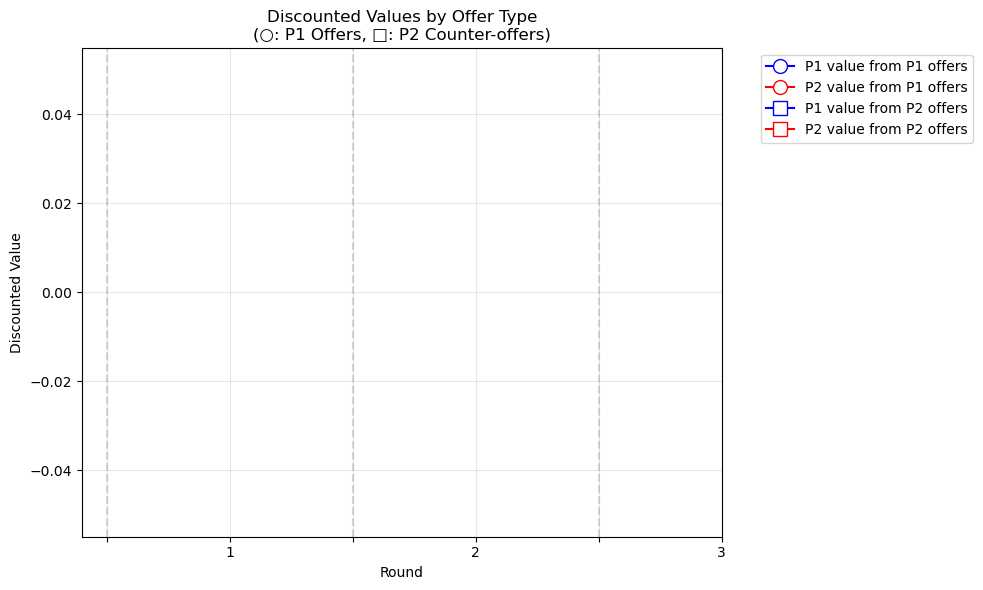

In [14]:
plot_discounted_values(rounds, p1_values, p2_values, max_rounds)


## Offer Evolution Plot

This visualization shows how the distribution of items changes over the negotiation rounds, with a separate subplot for each item type.

### Layout
- Creates a grid of subplots (2 columns)
- One subplot per item type
- For odd number of items, removes unused subplot

### Per Item Subplot
- X-axis: Negotiation rounds
- Y-axis: Number of units offered to P2
- Blue line (○): P1's offers
- Red line (○): P2's counter-offers
- Y-axis range: 0 to maximum units available for that item
- Grid shows valid integer unit values

### Interpretation
- Shows how many units of each item type each player offered to give to P2
- P1's remaining units = total_items - offered_units
- Converging lines suggest agreement being reached
- Diverging lines suggest areas of contention

Number of rounds: 0
Number of P1 offers: 0
Number of P2 offers: 0


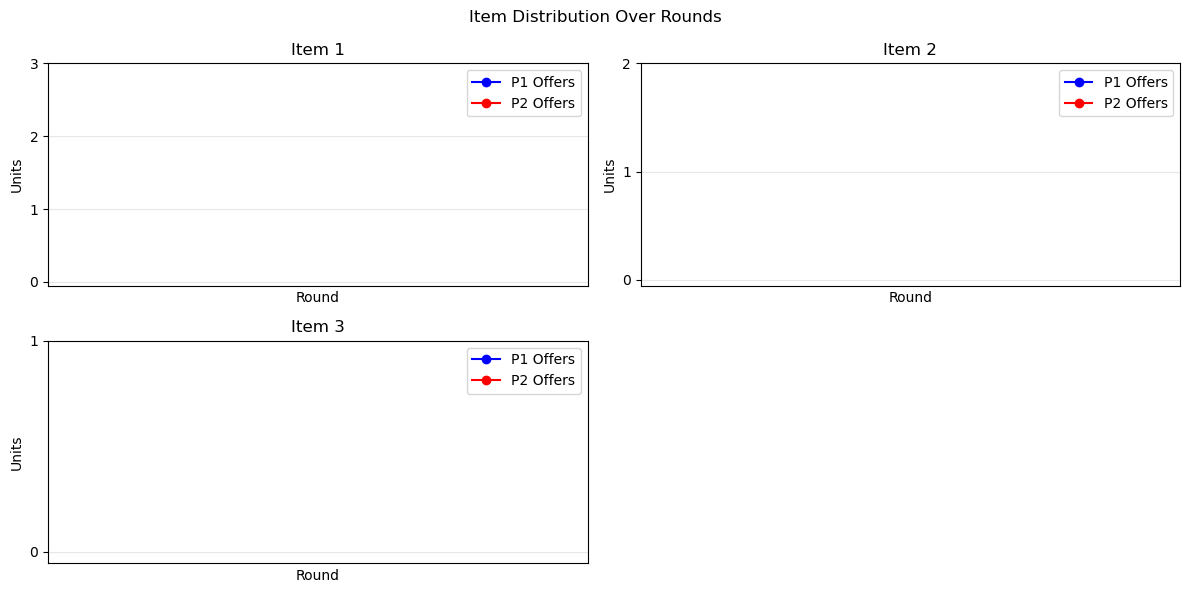

In [15]:
plot_offer_evolution(game, rounds, p1_offers, p2_offers)

In [16]:
def get_final_division(game):
    if game.current_offer: 
        p2_items = game.current_offer.offer  
        p1_items = [t - g for t, g in zip(game.items, p2_items)]  
        return {
            'P1': p1_items,
            'P2': p2_items
        }
    return None
evaluator = GameEvaluator(game)
outside_offer_rational = evaluator.evaluate_outside_offer_consistency()

if game.current_offer:
    final_division = get_final_division(game)
    value_gaps = [abs(p1 - p2) for p1, p2 in zip(p1_values, p2_values)] 
    fairness = [(p1/(p1+p2), p2/(p1+p2)) for p1, p2 in zip(p1_values, p2_values)]  

    print("\nBasic Metrics:")
    print(f"Final P1 Value: {p1_values[-1]:.2f}")
    print(f"Final P2 Value: {p2_values[-1]:.2f}")
    print(f"Final Value Gap: {value_gaps[-1]:.2f}")
    print(f"Final Fairness Ratio: {fairness[-1][0]:.2f} : {fairness[-1][1]:.2f}")
    print("\nFinal Division of Items:")
    if final_division:
        print(f"Total Items Available: {game.items}")
        print(f"P1 Received: {final_division['P1']}")
        print(f"P2 Received: {final_division['P2']}")
    else:
        print("No deal reached - no items were divided")

print("\nNegotiation Evaluation:")
print(f"Outside Offer Rational: {'Yes' if outside_offer_rational else 'No'}")

print(f"P1 Valuation of Each Item: {game.player_values[0]}")
print(f"P2 Valuation of Each Item: {game.player_values[1]}")

RuntimeError: dot : expected both vectors to have same dtype, but found Float and Long

## Check Pathologies
- Check if Pathologies Occured
- Check Count in game 
- Save to csv
